## Import Data ##

In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [461]:
from torch_geometric.datasets import WebKB

dataset = WebKB(root="/tmp/WebKB", name="Wisconsin")
data = dataset[0]

num_samples = data.num_nodes
train_mask = torch.zeros(num_samples, dtype=torch.bool)
val_mask = torch.zeros(num_samples, dtype=torch.bool)
test_mask = torch.zeros(num_samples, dtype=torch.bool)

train_mask[:int(0.8 * num_samples)] = 1
val_mask[int(0.8 * num_samples):int(0.9 * num_samples)] = 1
test_mask[int(0.9 * num_samples):] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

## Statistical Modeling ##

In [262]:
pd_data = pd.DataFrame(data.x.cpu().numpy())

In [264]:
pd_data.shape

(251, 1703)

In [268]:
pd_data.head(20).describe()

,0,1,2,3,4,5,6,7,8,9,...,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702
count,20.0,20.0,20.0,20.0,20.000000,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.000000,20.0,20.0,20.000000,20.000000,20.0,20.000000,20.0
mean,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.050000,0.0,0.0,0.050000,0.100000,0.0,0.800000,0.0
std,0.0,0.0,0.0,0.0,0.223607,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.223607,0.0,0.0,0.223607,0.307793,0.0,0.410391,0.0
min,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
25%,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0
50%,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0
75%,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.0
max,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0


In [286]:
def data_to_nx_subgraph(data, node_range):
    G = nx.Graph()
    
    start, end = node_range
    G.add_nodes_from(range(start, end))

    edge_index = data.edge_index
    edges = edge_index.t().tolist()

    filtered_edges = [
        (u, v) for u, v in edges if u >= start and u < end and v >= start and v < end
    ]

    G.add_edges_from(filtered_edges)
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

node_range = (0, len(pd_data))
G = data_to_nx_subgraph(data, node_range)

In [288]:
nx.cluster.average_clustering(G)

0.2076791942617057

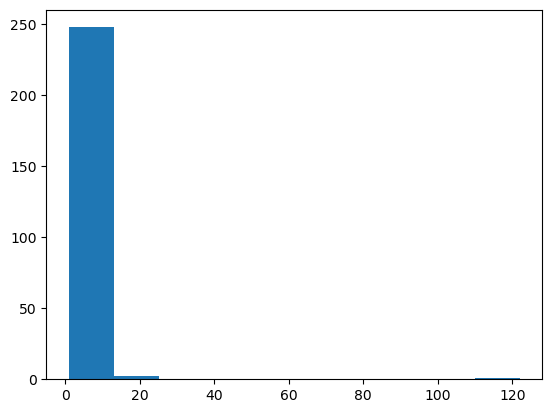

In [290]:
plt.hist([v for k, v in nx.degree(G)]);

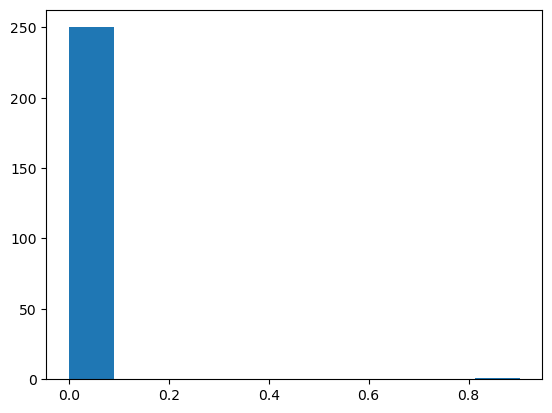

In [292]:
plt.hist(nx.centrality.betweenness_centrality(G).values());

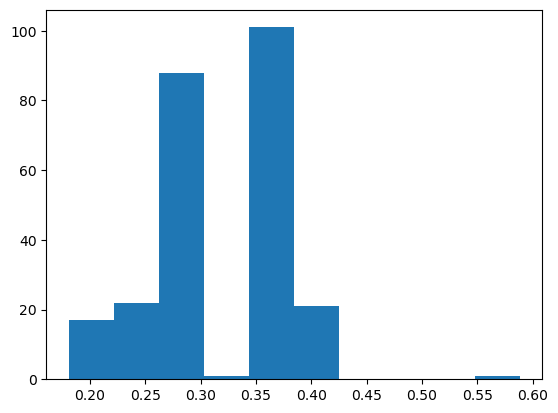

In [294]:
plt.hist(nx.centrality.closeness_centrality(G).values());

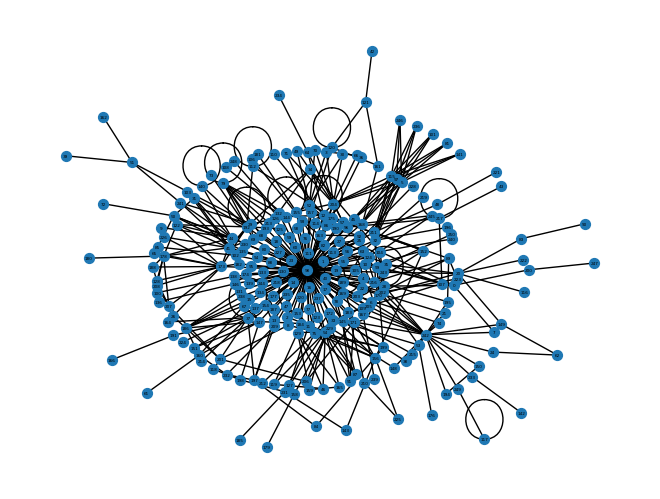

In [296]:
nx.draw_kamada_kawai(G, with_labels=True, node_size=50, font_size=3)

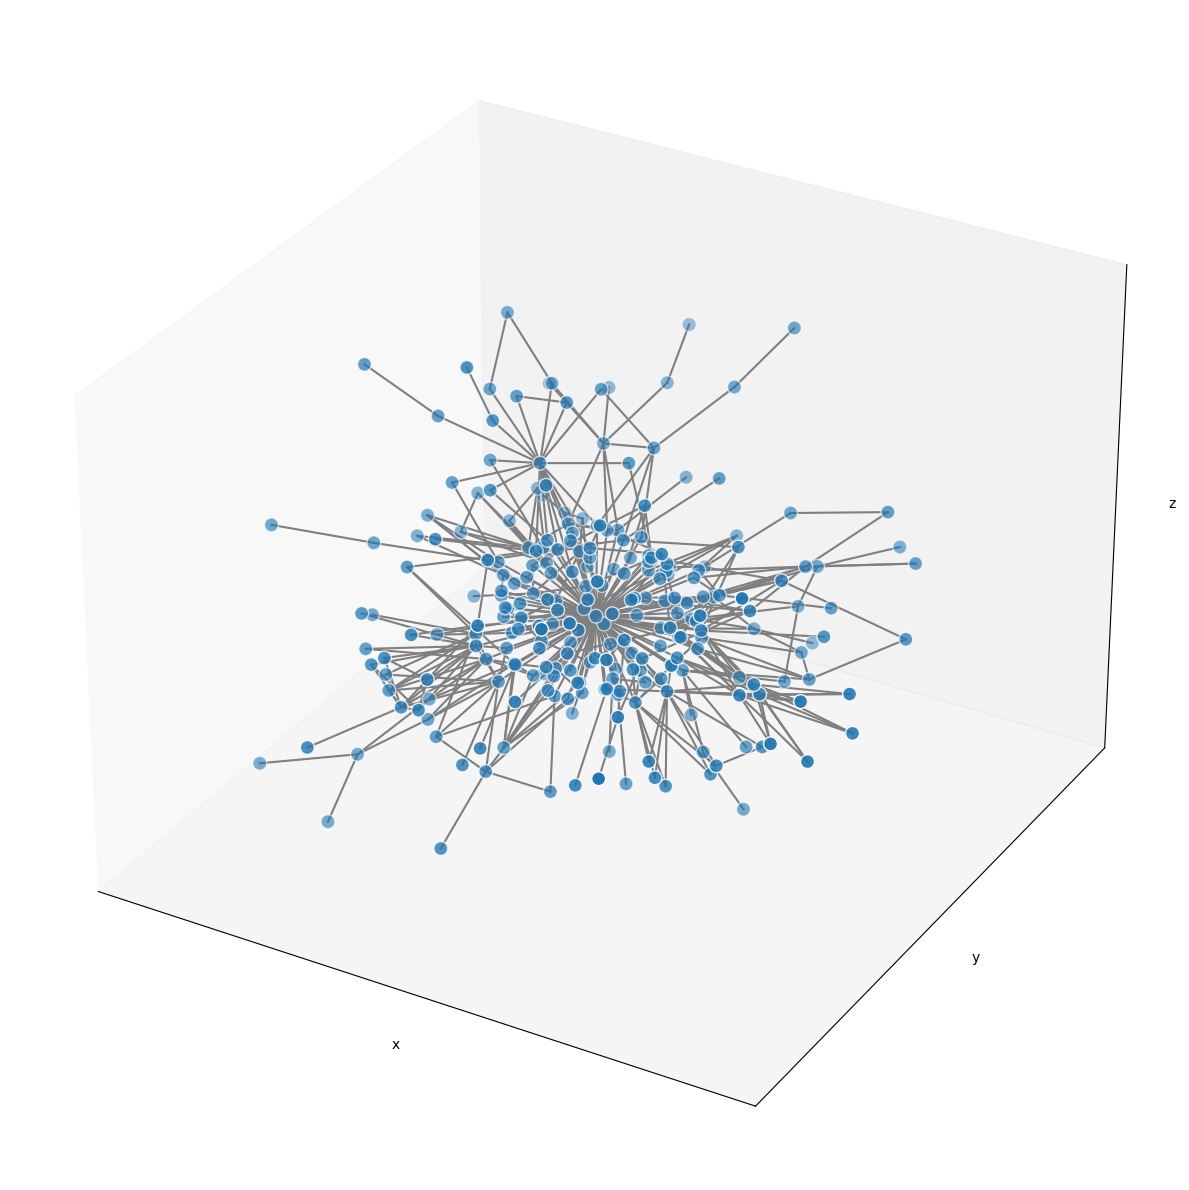

In [298]:
pos = nx.kamada_kawai_layout(G, dim=3)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(*node_xyz.T, s=100, ec="w")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    ax.grid(False)

    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

## Training Model ##

In [579]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        return x

In [619]:
LR = 1e-04
HIDDEN = 128
EPOCHS = 200

In [621]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [623]:
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           128
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       217,984
├─GCNConv: 1-2                           128
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       16,384
├─GCNConv: 1-3                           5
│    └─SumAggregation: 2-5               --
│    └─Linear: 2-6                       640
Total params: 235,269
Trainable params: 235,269
Non-trainable params: 0

In [625]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [627]:
start_time = time.time()

for epoch in range(EPOCHS):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {100*test_acc:.2f}%")

print("\nTraining Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch: 0, Loss: 1.6087, Test Accuracy: 34.62%
Epoch: 10, Loss: 1.3696, Test Accuracy: 65.38%
Epoch: 20, Loss: 1.2576, Test Accuracy: 61.54%
Epoch: 30, Loss: 1.1879, Test Accuracy: 53.85%
Epoch: 40, Loss: 1.1309, Test Accuracy: 50.00%
Epoch: 50, Loss: 1.0781, Test Accuracy: 53.85%
Epoch: 60, Loss: 1.0276, Test Accuracy: 53.85%
Epoch: 70, Loss: 0.9790, Test Accuracy: 53.85%
Epoch: 80, Loss: 0.9330, Test Accuracy: 53.85%
Epoch: 90, Loss: 0.8900, Test Accuracy: 53.85%
Epoch: 100, Loss: 0.8499, Test Accuracy: 53.85%
Epoch: 110, Loss: 0.8121, Test Accuracy: 50.00%
Epoch: 120, Loss: 0.7767, Test Accuracy: 46.15%
Epoch: 130, Loss: 0.7437, Test Accuracy: 46.15%
Epoch: 140, Loss: 0.7129, Test Accuracy: 42.31%
Epoch: 150, Loss: 0.6842, Test Accuracy: 42.31%
Epoch: 160, Loss: 0.6575, Test Accuracy: 38.46%
Epoch: 170, Loss: 0.6324, Test Accuracy: 38.46%
Epoch: 180, Loss: 0.6090, Test Accuracy: 38.46%
Epoch: 190, Loss: 0.5872, Test Accuracy: 38.46%

Training Time is:  0.2805  Seconds


## Post-Training Analysis ##

In [629]:
embeddings = []

def hook(module, input, output):
    embeddings.append(output.detach().cpu())

model.conv2.register_forward_hook(hook)

model.eval()
out = model(data.x, data.edge_index)

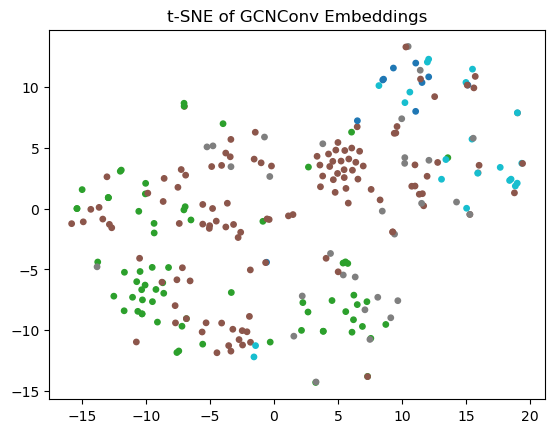

In [631]:
z = TSNE(n_components=2).fit_transform(embeddings[0].numpy())
plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

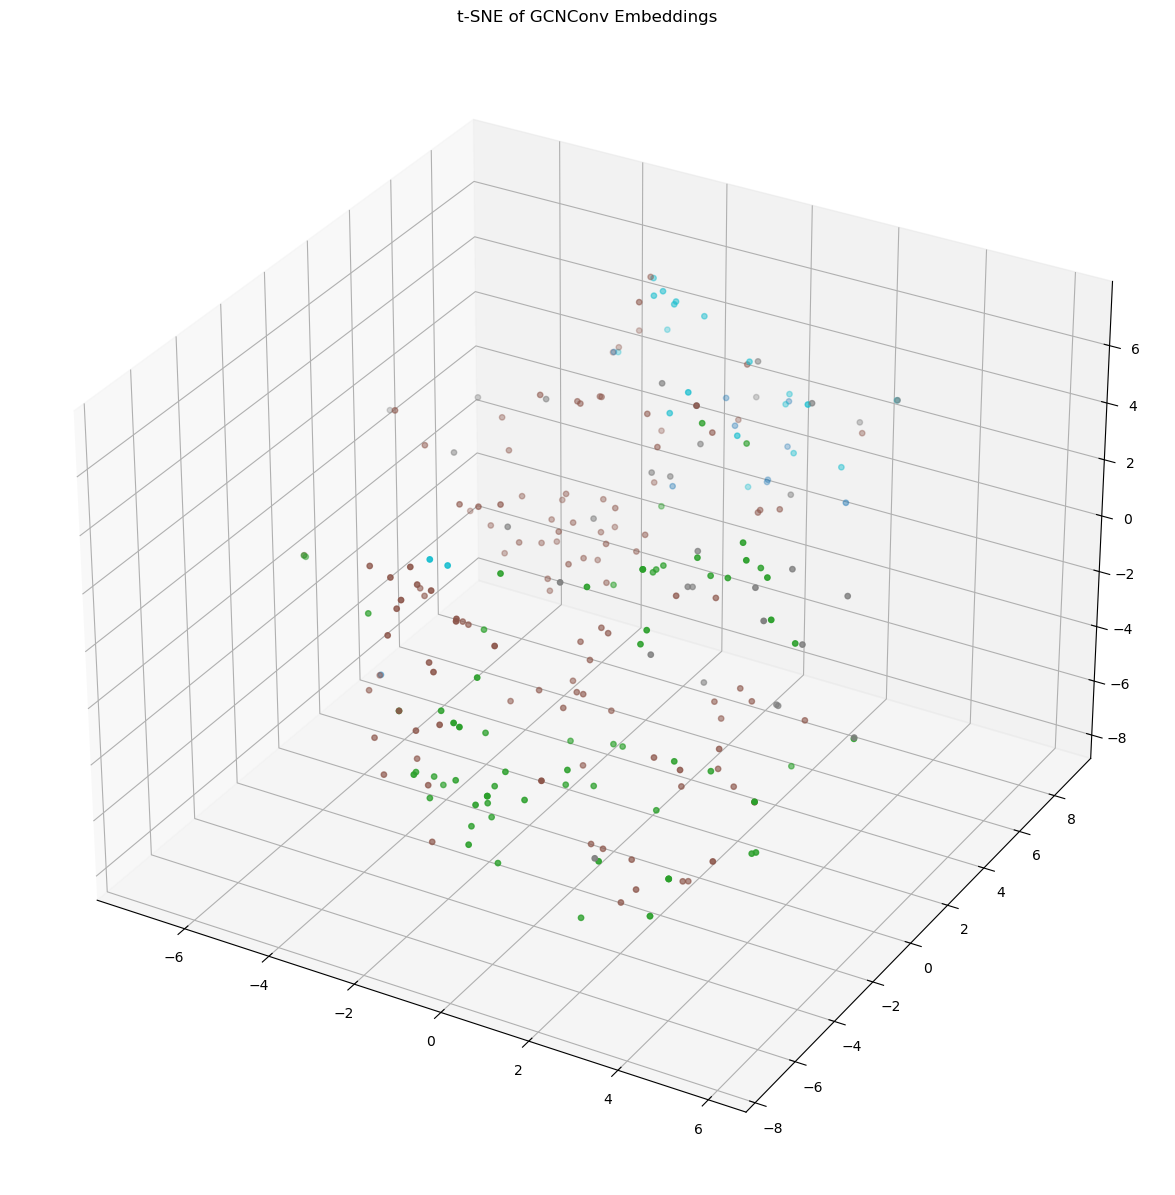

In [633]:
z = TSNE(n_components=3).fit_transform(embeddings[0].numpy())

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

In [635]:
probs = F.softmax(out, dim=1)
confidence, pred_class = probs.max(dim=1)

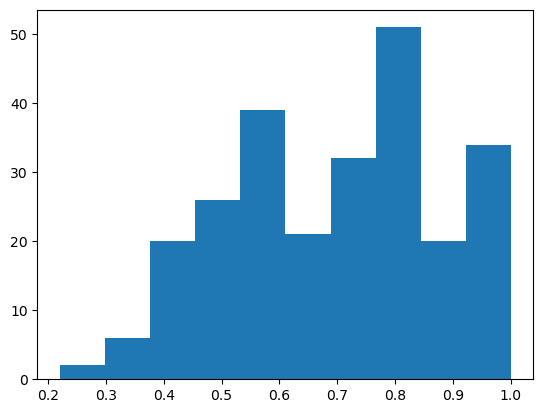

In [637]:
plt.hist(confidence.detach().numpy())
plt.show()

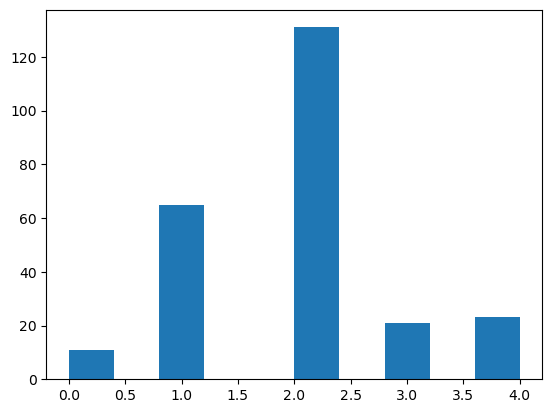

In [639]:
plt.hist(pred_class)
plt.show()

In [641]:
wrong = (pred_class != data.y).cpu()
wrong_nodes = torch.nonzero(wrong).flatten()

print(f"Number of Misclassified Nodes: {len(wrong_nodes.tolist())}")

Number of Misclassified Nodes: 70


In [643]:
torch.save(model.state_dict(), "Wisconsin.pth")

In [645]:
loaded_model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes).to(device)
loaded_model.load_state_dict(torch.load("Wisconsin.pth"))
loaded_model.eval()

GCN(
  (conv1): GCNConv(1703, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 5)
)